# UN Voting Analysis

Data available here: https://github.com/dmorgan26/UNGAvotes

Source: Erik Voeten "Data and Analyses of Voting in the UN General Assembly" Routledge Handbook of International
Organization, edited by Bob Reinalda (published 2017-06-19)

In [1]:
library(readr)

unvotes <- read_csv("C:\\Users\\Dan\\Desktop\\R\\Markdowns\\UN-Votes\\votes.csv", col_names=TRUE)

Parsed with column specification:
cols(
  assembly_session = col_integer(),
  rc_id = col_integer(),
  state_code = col_integer(),
  vote = col_integer()
)


### Variable Names

assembly_session - the annual session in which the vote was cast
rc_id - Roll Call ID, identifier for each piece of legislation on which the assembly voted
state_code - ID for each member state given by the Correlates of War project
vote - 1 = Yes, 2 = Abstain, 3 = No, 8 = Not Present, 9 = Not A Member 

In [3]:
library(dplyr, quietly=TRUE)
glimpse(unvotes)

Observations: 1,048,575
Variables: 4
$ assembly_session <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ rc_id            <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...
$ state_code       <int> 2, 20, 31, 40, 41, 42, 51, 52, 53, 54, 55, 56, 57,...
$ vote             <int> 1, 3, 9, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 9,...


### Data Cleaning

Removing absences and replacing assembly_session with year. First assembly vote in the data set was in 1946.

In [4]:
votes_processed <- unvotes %>%
                      filter(vote <= 3) %>%
                      mutate(year = assembly_session + 1945)

votes_processed <- votes_processed[,-1]

glimpse(votes_processed)

Observations: 722,082
Variables: 4
$ rc_id      <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...
$ state_code <int> 2, 20, 40, 41, 42, 70, 90, 91, 92, 93, 94, 95, 100, 101,...
$ vote       <int> 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ year       <dbl> 1946, 1946, 1946, 1946, 1946, 1946, 1946, 1946, 1946, 19...


### Replacing state_code with country name

In [5]:
library(countrycode)
votes_processed <- votes_processed %>%
                      mutate(country = countrycode(state_code, "cown", "country.name"))

Warning message in countrycode(state_code, "cown", "country.name"):
"Some values were not matched unambiguously: 260, 816
"

The data gives state_code as Correlates of War codes

260 = German Federal Republic (commonly known as West Germany). 
816 = Republic of Vietnam (commonly known as South Vietnam). 

Other relevant codes

255 = Germany
265 = East Germany

817 = Vietnam

In [6]:
code_260 <- votes_processed %>%
    filter(state_code == "260")

range(code_260$year)

[1] 1973 1989

In [7]:
code_265 <- votes_processed %>%
    filter(state_code == "265")

range(code_265$year)

[1] 1973 1989

In [8]:
code_255 <- votes_processed %>%
              filter(state_code == "255") 

range(code_255$year)

[1] 1990 2014

Data shows (unified) German votes from 1990-2014

There isn't any overlap of the dates so I will manually assign state_code 260 to West Germany


In [15]:
votes_processed$country[votes_processed$state_code == "260"] <- "West Germany"

code_816 <- votes_processed %>%
    filter(state_code == "816")

range(code_816$year)

[1] 1977 2014

In [18]:
code_817 <- votes_processed %>%
              filter(state_code == "817")

range(code_817$year)

dim(code_817)

Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"

[1]  Inf -Inf

[1] 0 5

There is no data for South Vietnam so I will manually assign state_code 816 to Vietnam

In [19]:
votes_processed$country[votes_processed$state_code == "816"] <- "Vietnam"

sum(is.na(votes_processed$country)) # all NAs removed

votes_processed <- votes_processed[,-2]

glimpse(votes_processed)

[1] 0

Observations: 722,082
Variables: 4
$ rc_id   <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...
$ vote    <int> 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ year    <dbl> 1946, 1946, 1946, 1946, 1946, 1946, 1946, 1946, 1946, 1946,...
$ country <chr> "United States", "Canada", "Cuba", "Haiti", "Dominican Repu...


### Exploring the "agreeableness" of countries at the UN

"Yes" votes as a proportion of all votes

In [20]:
percent_yes <- votes_processed %>%
    summarize (total = n(), percent_yes = mean(vote == 1))

percent_yes

total,percent_yes
722082,0.7971754


 79.9% of all votes on proposed resolutions were for "Yes"

### Summarizing by Year to use later

In [21]:
by_year <- votes_processed %>%
  group_by(year) %>%
    summarize(total = n(), percent_yes = mean(vote == 1))

### Summarizing by Country

In [24]:
by_country <- votes_processed %>%
  group_by(country) %>%
  summarize(total = n(), percent_yes = mean(vote == 1)) %>%
  arrange(percent_yes)

head(by_country)
dim(by_country)

country,total,percent_yes
Zanzibar,2,0.0000000
United States,5298,0.2840695
Palau,829,0.3063932
Israel,4850,0.3484536
West Germany,2067,0.3962264
Micronesia (Federated States of),1390,0.4100719


[1] 200   3

Zanzibar only has 2 votes, so filtering out countries with less than 100 votes

In [25]:
by_country <- by_country %>%
                        filter(total > 100)

dim(by_country)


[1] 199   3

Zanzibar is the only country that was removed

### Analysing Agreeableness Over Time

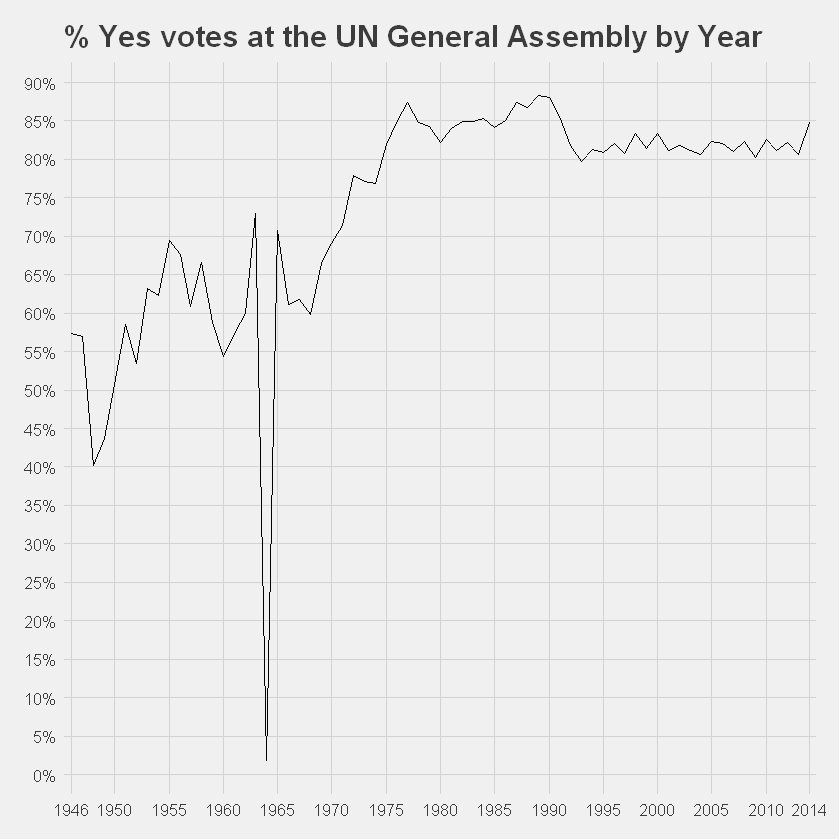

In [26]:
library(ggplot2)
library(ggthemes)

ggplot(by_year, aes(x=year, y=percent_yes)) + geom_line() + 
  scale_y_continuous(breaks = seq(0,1,0.05), labels=scales::percent) + 
  scale_x_discrete(limits = c(1946, seq(1950, 2010, 5), 2014)) +
  labs(title = "% Yes votes at the UN General Assembly by Year", y = "% Yes", x = "Year") +
  theme_fivethirtyeight()

### Investiating the huge dip

In [27]:
which.min(by_year$percent_yes)
by_year[17:21,]

[1] 19

year,total,percent_yes
1962,4642,0.59995692
1963,3308,0.72944377
1964,112,0.01785714
1965,4382,0.70789594
1966,5868,0.61111111


The year 1964 shows the total percentage of yes votes as 1.7%. The numbers for 1963 and 1965 are as expected at 72.9% and 70.8% respectively, so I will assume that this is an error and so will remove the year 1964 from the data set.

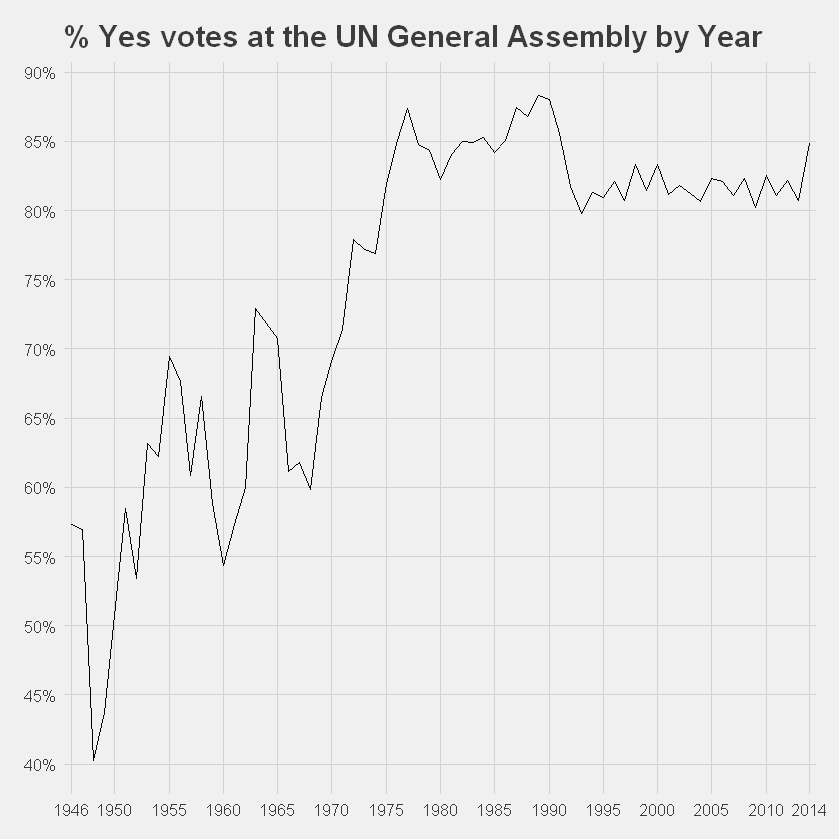

In [28]:
by_year <- by_year[-19,]

votes_processed <- votes_processed %>%
                      filter(year != "1964")

ggplot(by_year, aes(x=year, y=percent_yes)) + 
  geom_line() + 
  scale_y_continuous(breaks = seq(0,1,0.05), labels=scales::percent) + 
  scale_x_discrete(limits = c(1946, seq(1950, 2010, 5), 2014)) +
  labs(title = "% Yes votes at the UN General Assembly by Year", y = "% Yes", x = "Year") +
  theme_fivethirtyeight()

### Visualising trend in agreeableness for the entire assembly

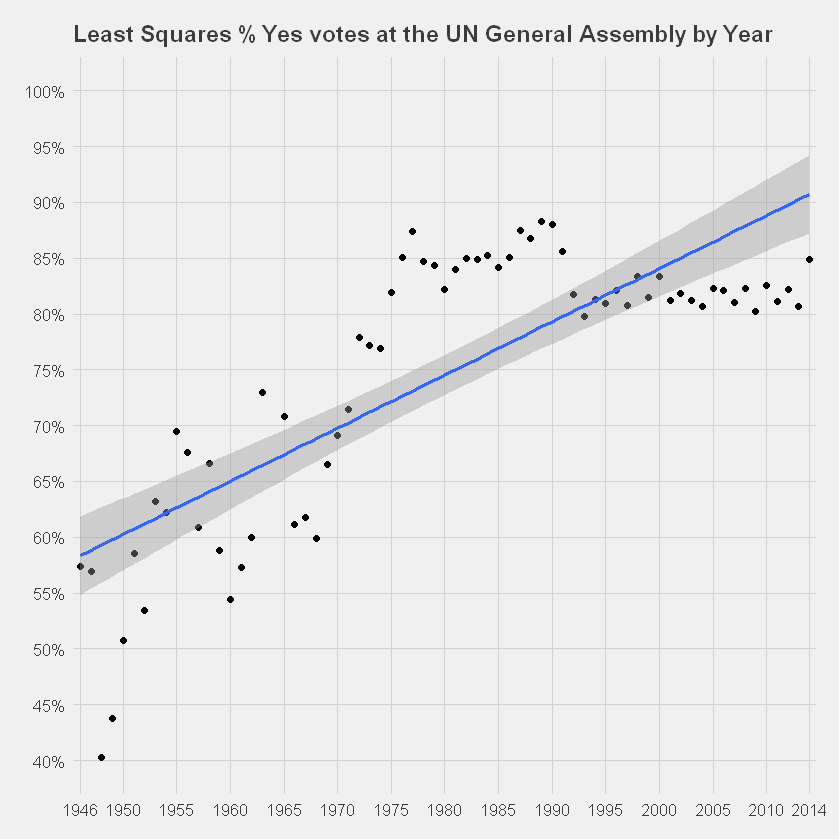

In [67]:
library(scales, quietly=TRUE)

ggplot(by_year, aes(x=year, y=percent_yes)) + 
  geom_point() + 
  geom_smooth(method="lm") + 
  scale_x_discrete(limits = c(1946, seq(1950, 2010, 5), 2014)) +
  scale_y_continuous(limits = c(0.4, 1), breaks = seq(0.4, 1, 0.05), labels=scales::percent) +  
  labs(title = "Least Squares % Yes votes at the UN General Assembly by Year", y = "% Yes", x = "Year") +
  theme_fivethirtyeight() + theme(plot.title = element_text(size=14))

### Voting Trends by Country

In [31]:
by_year_country <- votes_processed %>%
  group_by(year, country) %>%
  summarize(total = n(), percent_yes = mean(vote == 1))

### UK Agreeableness Over Time

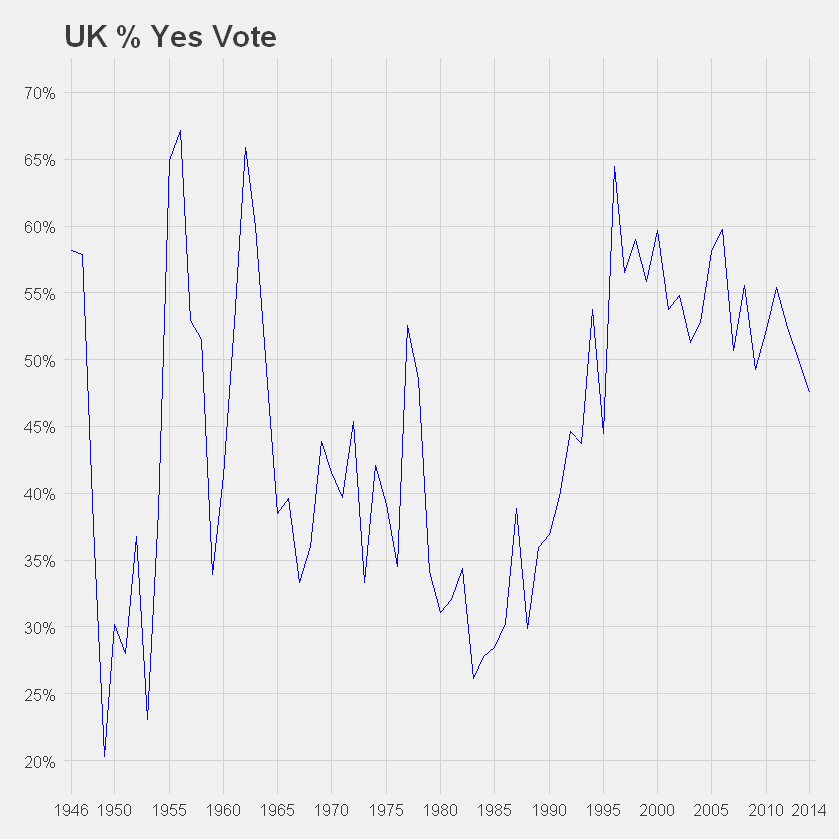

In [32]:
by_year_country %>%
  filter(country == "United Kingdom") %>%
     ggplot(aes(x=year, y=percent_yes)) + 
      geom_line(col="blue") +
      scale_x_discrete(limits = c(1946, seq(1950, 2010, 5), 2014)) +
      scale_y_continuous(limits = c(0.2, 0.7), breaks = seq(0.2, 0.7, 0.05), labels=scales::percent) + 
      labs(title = "UK % Yes Vote", y = "% Yes", x = "Year") +
  theme_fivethirtyeight()

### Comparing Agreeableness of Countries

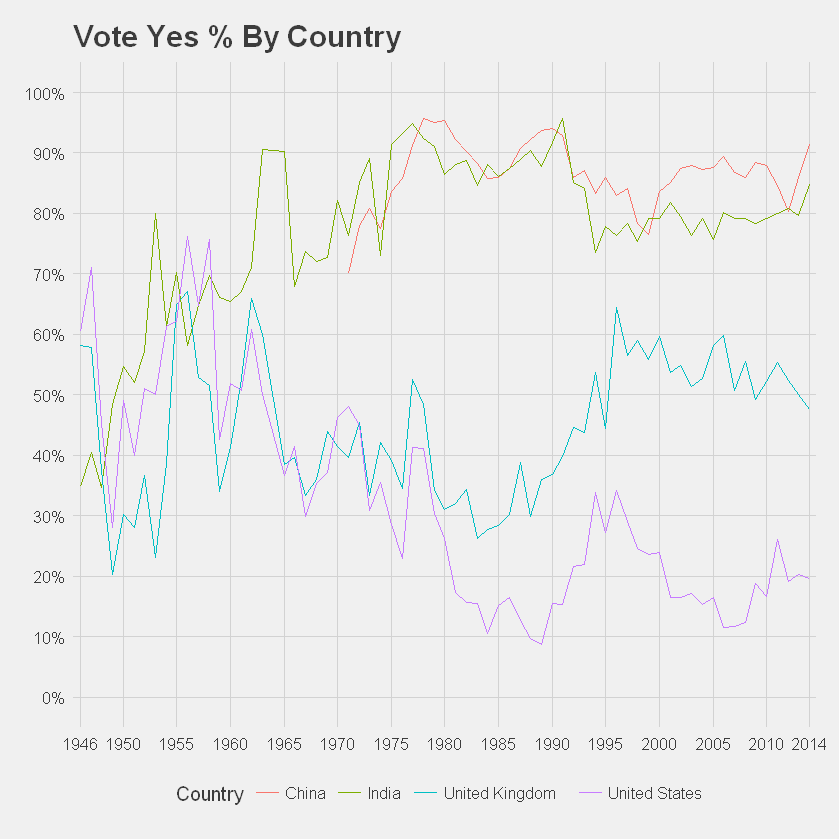

In [33]:
countries_line <- c("United Kingdom","United States","India","China")

by_year_country %>%
    filter(country %in% countries_line) %>%
    ggplot(aes(x=year, y=percent_yes, col=country)) + geom_line() +
      scale_x_discrete(limits = c(1946, seq(1950, 2010, 5), 2014)) +
      scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.1), labels=scales::percent) + 
      scale_color_discrete(name="Country") +
      labs(title = "Vote Yes % By Country", y = "% Yes", x = "Year") +
  theme_fivethirtyeight()

### Comparing too many countries to maintain a de-cluttered line plot

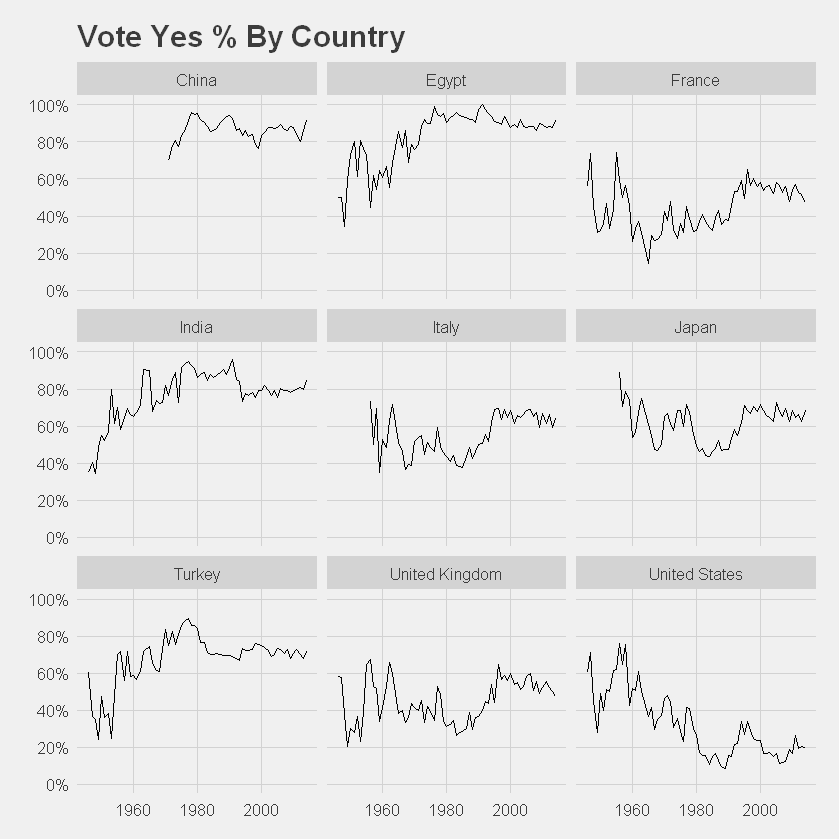

In [34]:
countries_facet <- c("United Kingdom","United States","India","China", "Japan", "France", "Italy", "Egypt","Turkey")

by_year_country %>%
  filter(country %in% countries_facet) %>%
  ggplot(aes(x=year, y=percent_yes)) + geom_line() + facet_wrap(~country) +
      scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.2), labels=scales::percent) +
      labs(title = "Vote Yes % By Country", y = "% Yes", x = "Year") +
  theme_fivethirtyeight() +
  theme(strip.background = element_rect(fill="lightgrey"))

### Modelling the trend of agreeableness for each country

In [36]:
library(tidyr)
library(purrr, quietly = TRUE)
library(broom)

by_year_country <- ungroup(by_year_country)

country_coefficients <- by_year_country %>%
                        nest(-country) %>%
                    mutate(model = map(data, ~ lm(percent_yes ~ year, data = .)), 
                           tidied = map(model, tidy)) %>%
                        unnest(tidied) %>%
                        filter(term == "year")

Obtaining adjusted p-values since we would expect some raw p-values to be < 0.05 by chance when we have 200 models

In [37]:
signif_country_coefficients <- country_coefficients %>%
                                  mutate(p.adjusted = p.adjust(p.value)) %>%
                                  filter(p.adjusted < 0.05)

### Which countries showed the largest change in agreeableness over time?

In [44]:
signif_country_coefficients %>%
  select(country, estimate) %>%
  arrange(desc(estimate)) %>%
    head(n=10)

country,estimate
Tuvalu,0.037765902
German Democratic Republic,0.019335631
Kyrgyzstan,0.011877771
Tajikistan,0.011550804
Kazakhstan,0.011543329
Yemen Arab Republic,0.011502731
South Africa,0.011486658
Malawi,0.010322697
Dominican Republic,0.007965362
Mongolia,0.007753252


Tuvalu is the nation whose agreeableness increased the most over their membership. The rate of increase is far larger than any other country so warrants further investigation

In [45]:
tuvalu <- by_year_country %>%
          filter(country == "Tuvalu")

max(tuvalu$year) - min(tuvalu$year)

[1] 13

Tuvalu has only had a voting record for 13 years. How many votes is that?

In [46]:
tuvalu %>%
    ungroup() %>%
    mutate(cumsum = cumsum(total)) %>%
    summarize(total_votes = max(cumsum))

total_votes
629


Tuvalu has participated in 629 votes, how does this compare to other nations?

In [47]:
summary(by_country$total)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    114    2380    4089    3629    4840    5316 

Tuvalu is a clear outlier here in a data set with significant left skew. 

If data is normally distributed I can see whether Tuvalu falls within three standard deviations of the mean

### Do the total number of votes cast by each nation follow a normal disribution?

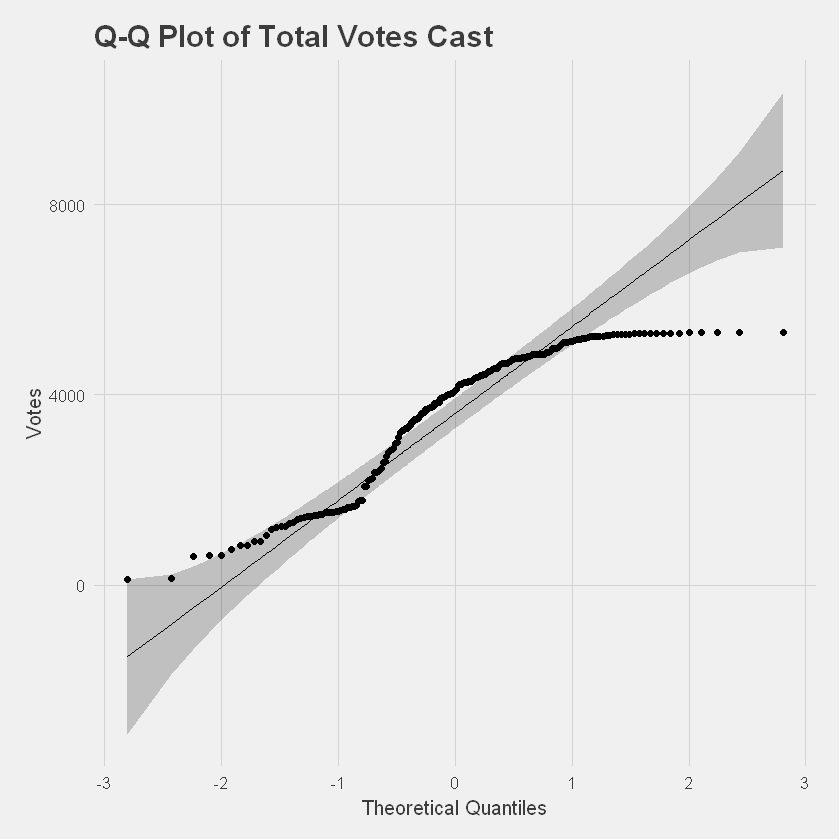

In [49]:
library(ggpubr, quietly=TRUE)
ggqqplot(by_country$total, main = "Q-Q Plot of Total Votes Cast By Each Country") +
  theme_fivethirtyeight() +
  theme(axis.title = element_text()) + ylab('Votes') + xlab('Theoretical Quantiles')

Shapiro-Wilk test 

H0 : The data are normally distributed 
HA : The data are not normally distributed

In [50]:
shapiro.test(by_country$total)


	Shapiro-Wilk normality test

data:  by_country$total
W = 0.88849, p-value = 5.326e-11


A p-value < 0.05 and near zero suggests that the we can reject the null hypothesis that the data are normally distributed. Visual inspection of the Q-Q plot also suggests that the distribution is not normal. 

560 votes seems like a large enough sample so I will keep Tuvalu in the data set.

### Whose agreeableness declined the most over time?

In [53]:
signif_country_coefficients %>%
    select(country, estimate) %>%
    arrange(estimate) %>%
    head(n=10)

country,estimate
Bosnia & Herzegovina,-0.013114172
Vanuatu,-0.011102543
South Korea,-0.007969444
United States,-0.006920787
Israel,-0.006609633
Yemen,-0.003945137
Djibouti,-0.001550616
Ukraine,0.002593617
Austria,0.002594383
Sweden,0.002626412


Bosnia & Herzagovinas agreeableness declined the most

### Investigating voting by issue

In [54]:
resolutions <- read_csv("C:\\Users\\Dan\\Desktop\\R\\Markdowns\\UN-Votes\\resolutions.csv", col_names=TRUE)

Parsed with column specification:
cols(
  assembly_session = col_integer(),
  vote_id = col_integer(),
  resolution = col_character(),
  amendment = col_integer(),
  vote_date = col_character(),
  significant_vote = col_integer(),
  yes_votes = col_integer(),
  no_votes = col_integer(),
  abstain = col_integer(),
  colonization = col_integer(),
  human_rights = col_integer(),
  israel_palestine = col_integer(),
  disarmament = col_integer(),
  nuclear_weapons = col_integer(),
  economic_development = col_integer()
)


### Cleaning to join to votes_processed

Locating NAs in the data set

In [55]:
nas <- vector(length = 15)

for (i in 1:15) {
  nas[i] <- sum(is.na(resolutions[,i]))
}

nas

[1]    0    0  151 2585    0    0    0    0    0   30   30   30   30   30   32

The vast majority of the NA values are mostly in the 'amendment' column which is of no interest so I will omit all NA values

In [56]:
resolutions <- na.omit(resolutions[,-c(4,6:9)])

resolutions_processed <- resolutions %>%
    mutate(year = assembly_session + 1945) %>%
    rename(rc_id = vote_id) %>%
    select(-assembly_session)

#Re-ordering columns to show the new 'Year' column first
resolutions_processed <- resolutions_processed[,c(10,1:9)]

votes_joined <- inner_join(votes_processed, resolutions_processed, by=c("rc_id","year"))

votes_joined_processed <- votes_joined %>%
                          rename(col = colonization, hr = human_rights, 
                          mid = israel_palestine, dis = disarmament, 
                          nuke = nuclear_weapons, eco = economic_development)

### How has a given member state voted on a given topic?

In [57]:
library(stringr)

plot_agreeableness_by_issue <- function(x, y) {
  
by_issue_output <- votes_joined_processed %>%
                    filter(country == x & y == 1) %>%
                    group_by(year) %>%
                    mutate(percent_yes = mean(vote == 1))
  
y <- deparse(substitute(y))

topics <- c("Colonisation", "Human Rights", "Israel Palestine", "Arms Control and Disarmament", "Nuclear Weapons", "Economic Development")

names(topics) <- c("col", "hr", "mid", "dis", "nuke", "eco")
   
  topiclabel <- str_sub(y, start = 24)
  label_output <- topics[topiclabel]
  

   ggplot(data = by_issue_output, aes(x = year, y = percent_yes)) + geom_line() +
          scale_y_continuous(labels = scales::percent) +
          labs(title = sprintf("Agreeableness of %s on the topic of %s", x, label_output)) +
          theme_fivethirtyeight() + theme(plot.title = element_text(size=12)) +
          scale_x_discrete(limits = c(1946, seq(1950, 2010, 5), 2014)) +
          theme(axis.title = element_text(), axis.title.x = element_text()) + ylab('%Yes') + xlab('Year')
  
  
}

### How has the US voted over time on issues of Nuclear Weapons?

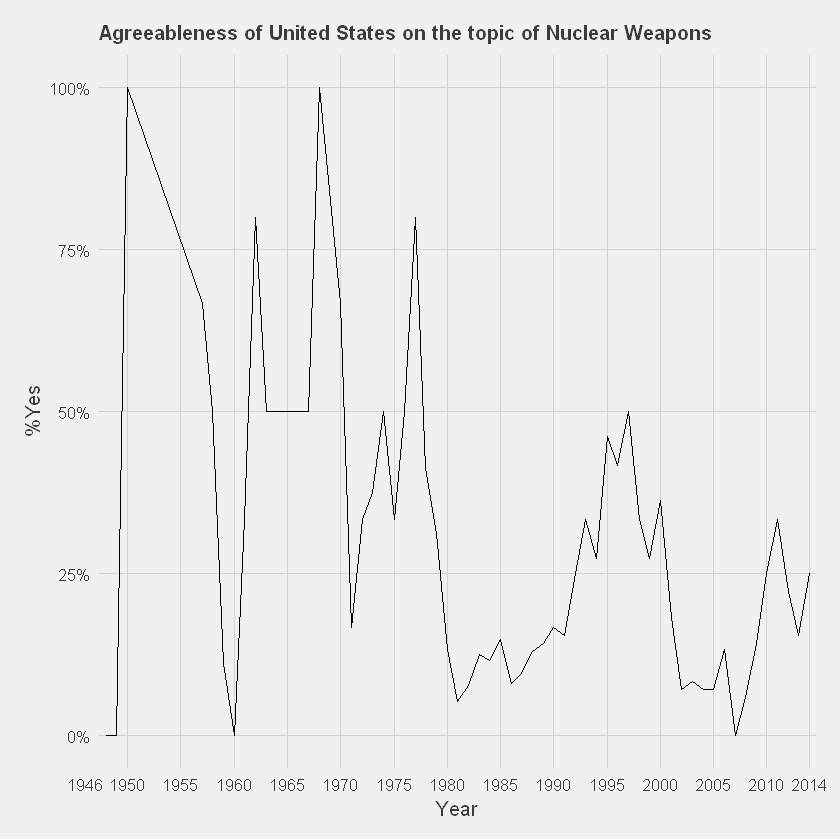

In [58]:
plot_agreeableness_by_issue("United States", votes_joined_processed$nuke)

### How has France voted over time on issues of Israel Palestine?

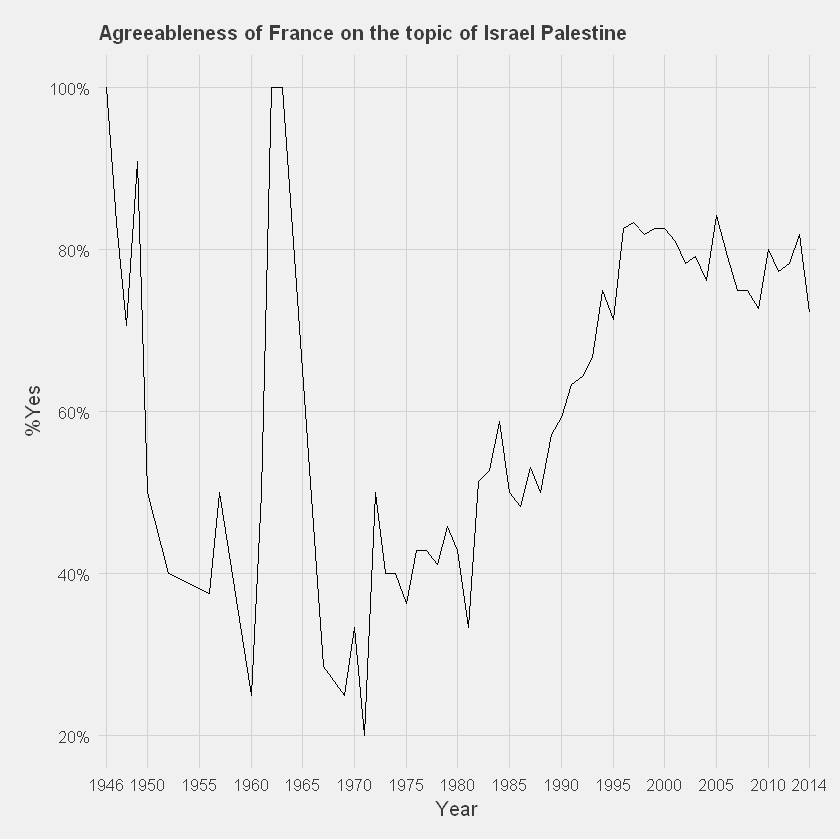

In [59]:
plot_agreeableness_by_issue("France", votes_joined_processed$mid)

### How did a given country vote on all issues?

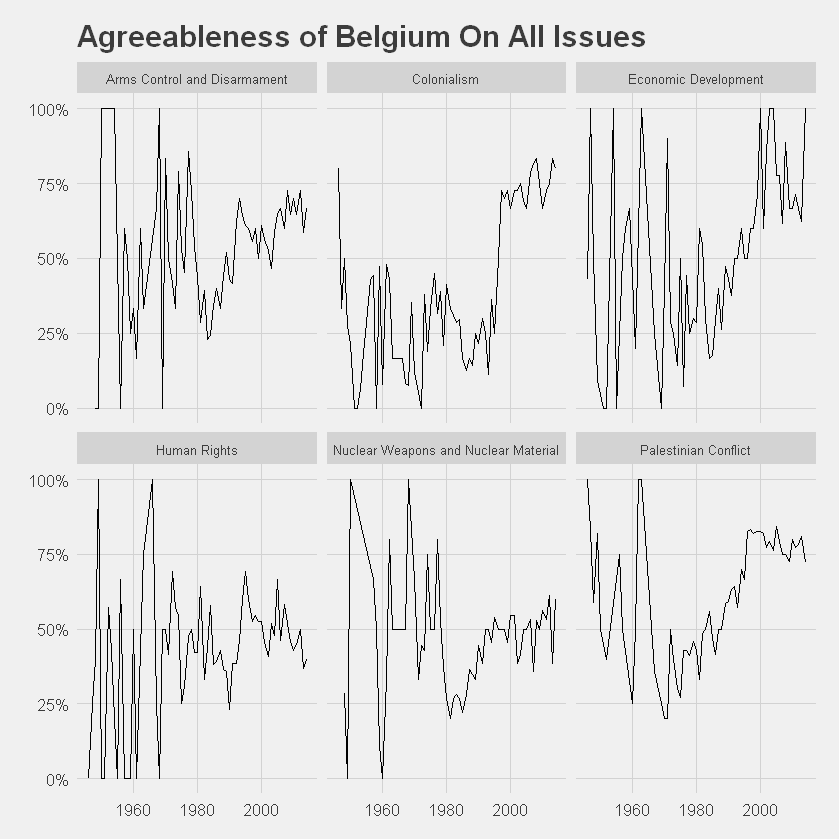

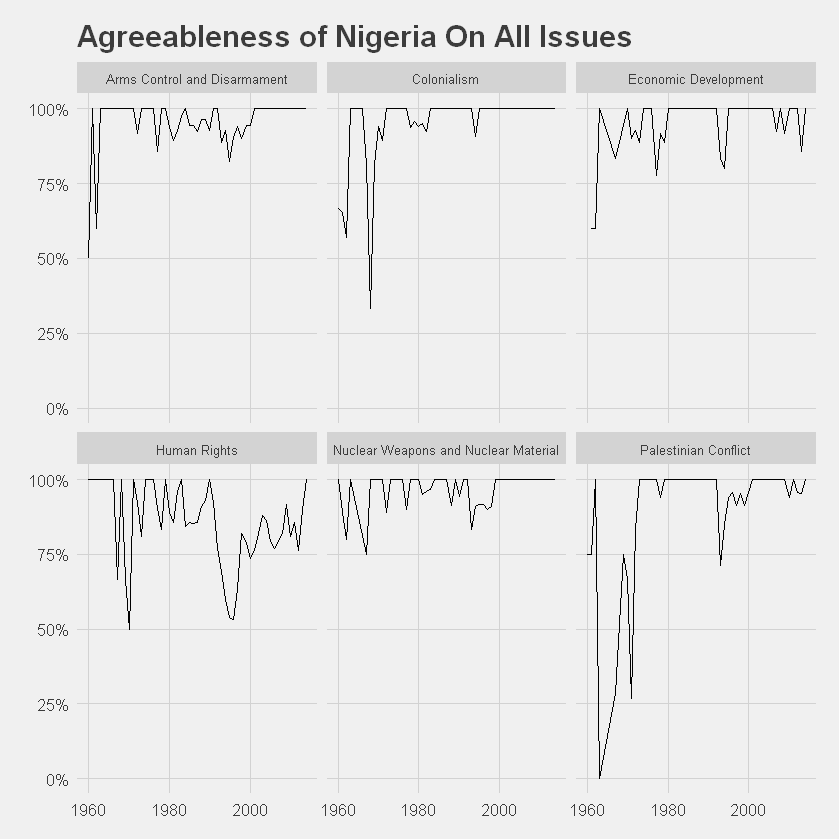

In [61]:
votes_gathered <- gather(votes_joined_processed, topic, has_topic, col:eco) %>%
                  filter(has_topic == 1)

votes_tidied <- votes_gathered %>%
  mutate(topic = recode(topic,
                        mid = "Palestinian Conflict",
                        nuke = "Nuclear Weapons and Nuclear Material",
                        dis = "Arms Control and Disarmament",
                        hr = "Human Rights",
                        col = "Colonialism",
                        eco = "Economic Development"))

by_country_year_topic <- votes_tidied %>%
                      group_by(country, year, topic) %>%
                        summarize(total = n(), percent_yes = mean(vote==1)) %>%
                        ungroup()
 
country_vote_all_topics <- function(x) {
  
  by_country_year_topic %>%
      filter(country == x) %>%
      ggplot(aes(x = year, y = percent_yes)) + geom_line() + facet_wrap(~ topic) +
      labs(title = sprintf("Agreeableness of %s On All Issues", x), x = "Year", y = "% Yes") +
      scale_y_continuous(label = scales::percent) +
      theme_fivethirtyeight() +
      theme(strip.background = element_rect(fill="lightgrey")) +
      theme(strip.text = element_text(size = 8))
   
  
}

country_vote_all_topics("Belgium")
country_vote_all_topics("Nigeria")

### How does the agreeableness of two countries compare over time on each topic?

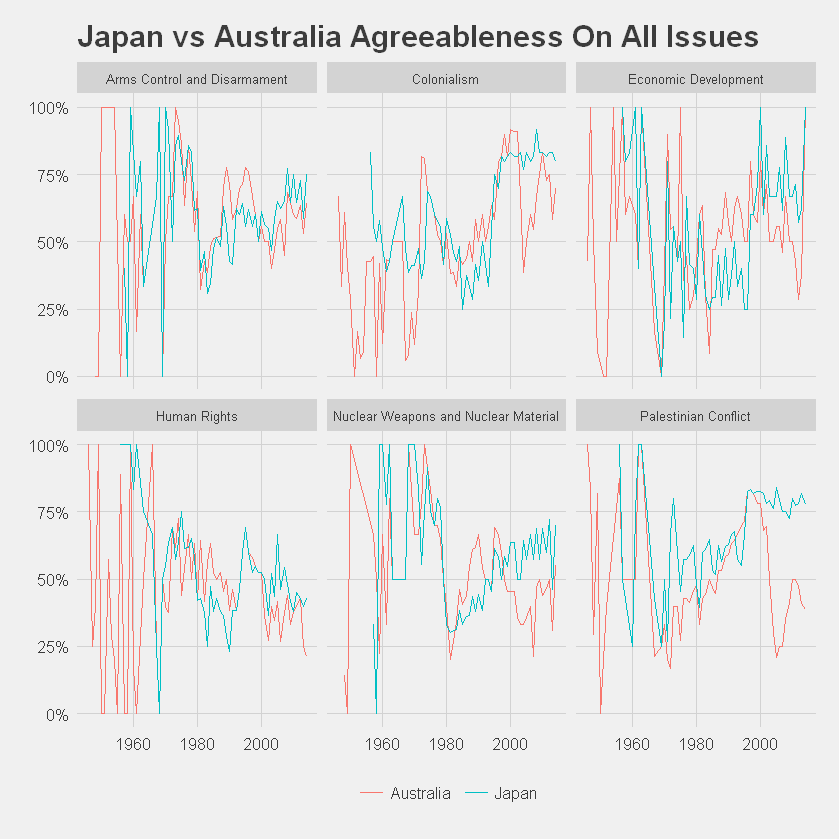

In [62]:
two_country_comparison <- function(x,y) {
  
  by_country_year_topic %>%
      filter(country == x | country == y) %>%
      ggplot(aes(x = year, y = percent_yes, color=country)) + geom_line() + facet_wrap(~ topic) +
      labs(title = paste(x,"vs", y, "Agreeableness On All Issues"), x = "Year", y = "% Yes") +
      scale_y_continuous(label = scales::percent) + 
      scale_color_discrete(name = NULL) +
      theme_fivethirtyeight() + 
      theme(strip.background = element_rect(fill="lightgrey")) +
      theme(strip.text = element_text(size = 8))
  
  
}

two_country_comparison("Japan","Australia")

### Whose agreeableness has increased/decreased the most over time on each topic?

In [64]:
country_topic_coefficients <- by_country_year_topic %>%
                              nest(-country, -topic) %>%
                              mutate(model = map(data, ~ lm(percent_yes ~ year, data = .)),
                                      tidied = map(model, tidy)) %>%
                                      unnest(tidied) %>%
                                      filter(term == "year") %>%
                                      mutate(p.adjusted = p.adjust(p.value)) %>%
                                      filter(p.adjusted < 0.05) %>%
                                      select(country, topic, estimate)

country_topic_coefficients %>% 
            arrange(desc(estimate)) %>%
            head(n=10)

Warning message in summary.lm(x):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(x):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(x):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(x):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(x):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(x):
"essentially perfect fit: summary may be unreliable"

country,topic,estimate
Uzbekistan,Economic Development,0.04217593
Tuvalu,Human Rights,0.04054205
German Democratic Republic,Nuclear Weapons and Nuclear Material,0.03618874
German Democratic Republic,Arms Control and Disarmament,0.03497694
Turkmenistan,Human Rights,0.03414532
Georgia,Colonialism,0.03074620
Kyrgyzstan,Human Rights,0.02968793
Germany,Colonialism,0.02481784
Estonia,Colonialism,0.02388081
Latvia,Colonialism,0.02125378


Uzbek attitudes to Economic Development and Tuvaluan attitudes to Human Rights have seen the largest conformist shift

In [65]:
country_topic_coefficients %>% 
            arrange(estimate) %>%
            head(n=10)

country,topic,estimate
Vanuatu,Palestinian Conflict,-0.02863227
Bosnia & Herzegovina,Human Rights,-0.02176193
Marshall Islands,Palestinian Conflict,-0.02013585
Marshall Islands,Human Rights,-0.01943271
Vanuatu,Colonialism,-0.01709499
Vanuatu,Human Rights,-0.01574621
South Korea,Human Rights,-0.01451094
Malta,Nuclear Weapons and Nuclear Material,-0.01130244
Cameroon,Human Rights,-0.01025933
United States,Palestinian Conflict,-0.01019875



Vanuatan attitudes to the Palestinian Conflict and Bosnian attitudes to Human Rights have shown the strongest non-conformist movements in voting patterns